<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Generar todos estados de la esfera de Poincaré </font>
</div>

- **Fecha**: 2022/03/23
        
- **Autores**: 
    - Javier Alda
    - Luis Miguel Sánchez Brea
    - Jesús del Hoyo

   
- **Estado**:  Development

- **Objetivos**: 
    - Queremos generar todos los estados de la esfera de poincaré
    - Queremos dibujar un mapa de bits encima de una esfera
   

- **Descripción** 
 

- **Referencias**: 
    https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere


- **Conclusiones**: 
   

# Importaciones

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import plotly.express as px
from scipy.special import sph_harm

In [3]:
def cart2sph(xyz, epsilon=1E-10):
    '''
    Convert Cartesian coordinate to spherical coordinate.

    input:
       xyz in (n, 3)
    return:
        r: norm
    theta: polar angle in [0, pi]
      phi: azimuthal angle in [0, 2 * pi]
    '''
    xyz = np.asarray(xyz, dtype=float)
    if xyz.ndim == 1:
        xyz = xyz[None, :]
    x, y, z = xyz.T

    # the azimuthal angle
    phi = np.arctan2(y, x)
    # np.arctan2 outputs angle in [-pi, pi]
    phi[phi < 0] += 2 * np.pi

    # the norm
    r = np.linalg.norm(np.c_[x, y, z], axis=1)
    # in case of zero division
    r[r < epsilon] = epsilon

    # the polar angle
    theta = np.arccos(z / r)

    return np.array([r, phi, theta])


def sph_c(xyz, l, m=None):
    '''
    Complex spherial harmonics including the Condon-Shortley phase.

    https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Spherical_harmonics

    input:
       xyz: cartesian coordinate of shape [n, 3]
    '''
    xyz = np.asarray(xyz, dtype=float)
    if xyz.ndim == 1:
        xyz = xyz[None, :]
    if m:
        assert -l <= m <= l, "'m' must be in the range of [{},{}]".format(-l, l)

    r, phi, theta = cart2sph(xyz)
    N = xyz.shape[0]
    ylm = [sph_harm(M, l, phi, theta) for M in range(-l, l+1)]

    if m is None:
        return np.array(ylm, dtype=complex).T
    else:
        return np.array(ylm, dtype=complex).T[:, m+l]


def sph_r(xyz, l, m=None):
    '''
    Real spherial harmonics.

    https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics
    '''
    ylm_c = sph_c(xyz, l)
    u = sph_u_c2r(l)

    if m is None:
        return np.dot(ylm_c, u.T).real
    else:
        return np.dot(ylm_c, u.T).real[:, m+l]


def sph_u_c2r(l):
    '''
    Set up transformation matrix complex->real spherical harmonics.

    please refer to:
    https://en.wikipedia.org/wiki/Spherical_harmonics#Real_form
    U_R2C is the conjugate transpose of U_C2R
    '''

    # A strange bug:
    # https://stackoverflow.com/questions/9887549/negative-exponent-with-numpy-array-operand/42776488
    l = int(l)

    TLP1 = 2 * l + 1
    U_C2R = np.zeros((TLP1, TLP1), dtype=complex)

    sqrt2inv = 1.0 / np.sqrt(2.0)
    for ii in range(TLP1):
        M = ii - l
        if (M < 0):
            U_C2R[ii, ii] = 1j * sqrt2inv
            U_C2R[ii, -(ii+1)] = -1j * (-1)**M * sqrt2inv
        if (M == 0):
            U_C2R[ii, ii] = 1.0
        if (M > 0):
            U_C2R[ii, -(ii+1)] = sqrt2inv
            U_C2R[ii, ii] = (-1)**M * sqrt2inv

    return U_C2R


def sph_u_r2c(l):
    '''
    Transformation matrix real->complex spherical harmonics
    '''
    return sph_u_c2r(l).conj().T


def show_sph_harm(l, m, real=True, N=50, use_sphere=True, plot='mpl'):
    '''
    Show the spherical harmonics on a unit sphere
    '''

    assert plot.lower() in ['mpl', 'mayavi', 'plotly']

    theta = np.linspace(0, np.pi, N)
    phi = np.linspace(0, 2*np.pi, N)
    theta, phi = np.meshgrid(theta, phi)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    xyz = np.c_[x.ravel(), y.ravel(), z.ravel()]

    # from time import time
    # t0 = time()
    if real:
        ylm = sph_r(xyz, l, m).reshape(N, N)
    else:
        ylm = sph_c(xyz, l, m).reshape(N, N).real
    # t1 = time()
    # print(t1 - t0)

    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = ylm
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)
    if not use_sphere:
        r0 = np.abs(ylm)

    if plot.lower() == 'mpl':
        import matplotlib.pyplot as plt
        from matplotlib import cm, colors
        from mpl_toolkits.mplot3d import Axes3D

        # Set the aspect ratio to 1 so our sphere looks spherical
        fig = plt.figure(
            figsize=plt.figaspect(1.)
        )
        ax = fig.add_subplot(111, projection='3d')

        if use_sphere:
            ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                            facecolors=cm.seismic(fcolors))
            xmax = ymax = zmax = np.max([x, y, z])
            xmin = ymin = zmin = np.min([x, y, z])
        else:
            ax.plot_surface(x*r0, y*r0, z*r0,  rstride=1, cstride=1,
                            facecolors=cm.seismic(fcolors))
            xmax = ymax = zmax = np.max([r0*x, r0*y, r0*z])
            xmin = ymin = zmin = np.min([r0*x, r0*y, r0*z])

        # Turn off the axis planes
        # ax.set_axis_off()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    elif plot == 'mayavi':
        from mayavi import mlab
        fig = mlab.figure(
            size=(800, 800),
            bgcolor=(1,1,1)
        )

        if use_sphere:
            mlab.mesh(x, y, z, colormap='seismic', scalars=fcolors)
        else:
            mlab.mesh(x*r0, y*r0, z*r0, colormap='seismic', scalars=fcolors)

        mlab.orientation_axes()
        mlab.show()

    else:
        import plotly.graph_objects as go

        if use_sphere:
            fig = go.Figure(
            data=[
                go.Surface(
                z=z, x=x, y=y,
                surfacecolor=fcolors,
                colorscale='balance', showscale=False, opacity=1.0,
                hoverinfo='none'
                )
            ],
            )
        else:
            fig = go.Figure(
                data=[
                    go.Surface(
                    z=r0*z, x=r0*x, y=r0*y,
                    surfacecolor=fcolors,
                    colorscale='balance', showscale=False, opacity=1.0,
                    hoverinfo='none'
                    )
                ],
            )

        fig.update_layout(
            width=800, height=800,
        )
        fig.show()

In [4]:
def show_sphere( N=50,  plot='mpl'):
    '''
    Show the spherical harmonics on a unit sphere
    '''
    use_sphere = True
    assert plot.lower() in ['mpl', 'mayavi', 'plotly']

    theta = np.linspace(0, np.pi, N)
    phi = np.linspace(0, 2*np.pi, N)
    theta, phi = np.meshgrid(theta, phi)
    r0 = 1

    # The Cartesian coordinates of the unit sphere
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    colors_lm=(np.cos(2*np.pi*(x+y+z)/1))

    colors_black= np.ones_like(x)

    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = colors_lm
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)
    # if not use_sphere:
    #     r0 = np.abs(ylm)

    angle=np.linspace(0,2*np.pi,100)
    x_line=np.cos(angle)
    y_line =np.sin(angle)
    z_line = np.zeros_like(angle)
    color = x_line+y_line+z_line
    color = (color-color.min())/(color.max()-color.min())
    #color = 'black'



    if plot.lower() == 'mpl':
        import matplotlib.pyplot as plt
        from matplotlib import cm, colors
        from mpl_toolkits.mplot3d import Axes3D

        # Set the aspect ratio to 1 so our sphere looks spherical
        fig = plt.figure(
            figsize=plt.figaspect(1.)
        )
        ax = fig.add_subplot(111, projection='3d')

        if use_sphere:
            ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                            facecolors=cm.seismic(fcolors))
            xmax = ymax = zmax = np.max([x, y, z])
            xmin = ymin = zmin = np.min([x, y, z])
        else:
            ax.plot_surface(x*r0, y*r0, z*r0,  rstride=1, cstride=1,
                            facecolors=cm.seismic(fcolors))
            xmax = ymax = zmax = np.max([r0*x, r0*y, r0*z])
            xmin = ymin = zmin = np.min([r0*x, r0*y, r0*z])

        # Turn off the axis planes
        # ax.set_axis_off()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    elif plot == 'mayavi':
        from mayavi import mlab
        fig = mlab.figure(
            size=(800, 800),
            bgcolor=(1,1,1)
        )

        if use_sphere:
            mlab.mesh(x, y, z, colormap='seismic', scalars=fcolors)
        else:
            mlab.mesh(x*r0, y*r0, z*r0, colormap='seismic', scalars=fcolors)

        mlab.orientation_axes()
        mlab.show()

    else:
        import plotly.graph_objects as go

        sphere_1 = go.Surface(z=z, x=x, y=y,  surfacecolor=fcolors,  colorscale='balance', showscale=True, opacity=0.25,   hoverinfo='none'      )
        sphere_2 = go.Surface(z=z, x=x, y=y, surfacecolor=colors_black,  colorscale='balance', showscale=True, opacity=0.75,   hoverinfo='none'      )
        sphere_3 = go.Surface(z=z, x=x, y=y,  surfacecolor=fcolors,  colorscale='balance', showscale=True, opacity=1,   hoverinfo='none'      )
        line_1 = go.Scatter3d( x=x_line, y=y_line, z=z_line,   marker=dict( size=3,  color='black',    colorscale='rdbu',  ) ) # line=dict(   color=color,    width=0.25  ),
        line_2 = go.Scatter3d( x=x_line, y=y_line, z=z_line,  line=dict(   color=color,    width=0.25  ))
        line_3 = go.Scatter3d( x=x_line, y=y_line, z=z_line,   marker=dict( size=2,  color='black',    colorscale='rdbu',  ) ) # line=dict(   color=color,    width=0.25  ),

        if use_sphere:
            fig = go.Figure(data=[sphere_2, line_3 ])
        else:
            fig = go.Figure(
                data=[
                    go.Surface(
                    z=r0*z, x=r0*x, y=r0*y,
                    surfacecolor=fcolors,
                    colorscale='balance', showscale=False, opacity=1.0,
                    hoverinfo='none'
                    )
                ],
            )

        #fig.update_layout(width=1600, height=800,)
        fig.show()

In [5]:
def line():
    import plotly.graph_objects as go

    x=np.linspace(0,1,500)
    y = x**2
    z = np.sin(x)
    color = x-y-z
    color = (color-color.min())/(color.max()-color.min())
    #color = 'black'

    fig = go.Figure(data=go.Scatter3d(
        x=x, y=y, z=z,
        # marker=dict(
        #     size=2,
        #     color=color,
        #     colorscale='rdbu',
        # ),
        line=dict(
            color=color,
            width=1
        )
    ))

    fig.update_layout(        width=800,        height=600,        autosize=True,
        scene=dict(
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=0,
                    y=1.0707,
                    z=1,
                )
            ),
            aspectratio = dict( x=1, y=1, z=1),
            aspectmode = 'manual'
        ),
    )

    fig.show()

In [6]:
line()

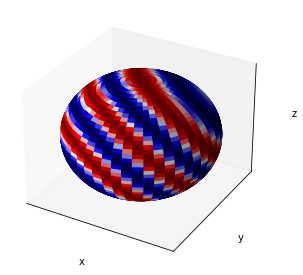

In [7]:
show_sphere( N=50,  plot='mpl')

In [8]:
show_sphere( N=50,  plot='plotly')

In [9]:
show_sphere( N=50,  plot='mayavi')

: 